# Binary Classification Model for Heart Disease Study Using Python Take 4
### David Lowe
### May 27, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Heart Disease dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: The original database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by machine learning researchers to this date. The "num" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

In iteration Take1, we examined the Cleveland dataset and created a Logistic Regression model to fit the data.

In iteration Take2, we examined the Hungarian dataset and created a Logistic Regression model to fit the data.

In iteration Take3, we examined the Switzerland dataset and created an Extra Trees model to fit the data.

In this iteration, we will examine the Long Beach VA dataset and look for a suitable machine learning model to fit the data.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 73.45%. Two algorithms (Logistic Regression and Extra Trees) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Extra Trees turned in the top overall result and achieved an accuracy metric of 77.85%. By using the optimized parameters, the Extra Trees algorithm processed the testing dataset with an accuracy of 66.66%, which was significantly below the prediction accuracy gained from the training data.

CONCLUSION: For the Long Beach VA dataset, the Extra Trees algorithm achieved the best overall results using the training and testing datasets. For this dataset, Extra Trees should be considered for further modeling or production use.

Dataset Used: Heart Disease Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

One potential source of performance benchmark: https://www.kaggle.com/ronitf/heart-disease-uci

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + ' downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
colNames = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']
xy_original_df = read_csv(inputFile, names=colNames, sep=',', header=None, index_col=False, na_values="?")

In [5]:
# Take a peek at the dataframe after the import
xy_original_df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,4,140.0,260.0,0.0,1,112.0,1.0,3.0,2.0,NaN,NaN,2
1,44,1,4,130.0,209.0,0.0,1,127.0,0.0,0.0,NaN,NaN,NaN,0
2,60,1,4,132.0,218.0,0.0,1,140.0,1.0,1.5,3.0,NaN,NaN,2
3,55,1,4,142.0,228.0,0.0,1,149.0,1.0,2.5,1.0,NaN,NaN,1
4,66,1,3,110.0,213.0,1.0,2,99.0,1.0,1.3,2.0,NaN,NaN,0
5,66,1,3,120.0,0.0,0.0,1,120.0,0.0,-0.5,1.0,NaN,NaN,0
6,65,1,4,150.0,236.0,1.0,1,105.0,1.0,0.0,NaN,NaN,NaN,3
7,60,1,3,180.0,0.0,0.0,1,140.0,1.0,1.5,2.0,NaN,NaN,0
8,60,1,3,120.0,0.0,NaN,0,141.0,1.0,2.0,1.0,NaN,NaN,3
9,60,1,2,160.0,267.0,1.0,1,157.0,0.0,0.5,2.0,NaN,NaN,1


In [6]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
age         200 non-null int64
sex         200 non-null int64
cp          200 non-null int64
trestbps    144 non-null float64
chol        193 non-null float64
fbs         193 non-null float64
restecg     200 non-null int64
thalach     147 non-null float64
exang       147 non-null float64
oldpeak     144 non-null float64
slope       98 non-null float64
ca          2 non-null float64
thal        34 non-null float64
num         200 non-null int64
dtypes: float64(9), int64(5)
memory usage: 22.0 KB


In [7]:
print(xy_original_df.isnull().sum())

age           0
sex           0
cp            0
trestbps     56
chol          7
fbs           7
restecg       0
thalach      53
exang        53
oldpeak      56
slope       102
ca          198
thal        166
num           0
dtype: int64


### 1.d) Data Cleaning

In [8]:
# Not applicable for this iteration of the project
# Sample code for performing one-hot-encoding
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
# x_train_df = get_dummies(x_train_df)
# print(x_train_df.dtypes)

In [9]:
# Due to the large number of missing data in these columns, we will drop them from the datasets
xy_original_df.drop(columns=['ca','thal'], inplace=True)

# Perform some immediate cleaning tasks to get data into the right formats and types
xy_original_df.age = xy_original_df.age.astype(int)
xy_original_df.sex = xy_original_df.sex.astype(int)
xy_original_df.sex = xy_original_df.sex.astype('category')
xy_original_df.cp = xy_original_df.cp.astype(int)
xy_original_df.cp = xy_original_df.cp.astype('category')
xy_original_df.restecg = xy_original_df.restecg.astype(int)
xy_original_df.restecg = xy_original_df.restecg.astype('category')

# impute the missing values into the primary diagnostic fields
xy_original_df['trestbps'].fillna(value=xy_original_df['trestbps'].median(), inplace=True)
xy_original_df.trestbps = xy_original_df.trestbps.astype(int)

xy_original_df['chol'].fillna(value=xy_original_df['chol'].median(), inplace=True)
xy_original_df.chol = xy_original_df.chol.astype(int)

xy_original_df['fbs'].fillna(0, inplace=True)
xy_original_df.fbs = xy_original_df.fbs.astype(int)
xy_original_df.fbs = xy_original_df.fbs.astype('category')

xy_original_df['thalach'].fillna(value=xy_original_df['thalach'].median(), inplace=True)
xy_original_df.thalach = xy_original_df.thalach.astype(int)

xy_original_df['exang'].fillna(0, inplace=True)
xy_original_df.exang = xy_original_df.exang.astype(int)
xy_original_df.exang = xy_original_df.exang.astype('category')

xy_original_df['oldpeak'].fillna(value=xy_original_df['oldpeak'].mean(), inplace=True)

xy_original_df['slope'].fillna(2, inplace=True)
xy_original_df.slope = xy_original_df.slope.astype(int)
xy_original_df.slope = xy_original_df.slope.astype('category')

In [10]:
def reClassNum(num_code):
    if (num_code > 1) :
        return 1
    else :
        return num_code
xy_original_df['num'] = xy_original_df['num'].apply(reClassNum)

In [11]:
# Take a peek at the dataframe after the transformation
xy_original_df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
0,63,1,4,140,260,0,1,112,1,3.0,2,1
1,44,1,4,130,209,0,1,127,0,0.0,2,0
2,60,1,4,132,218,0,1,140,1,1.5,3,1
3,55,1,4,142,228,0,1,149,1,2.5,1,1
4,66,1,3,110,213,1,2,99,1,1.3,2,0
5,66,1,3,120,0,0,1,120,0,-0.5,1,0
6,65,1,4,150,236,1,1,105,1,0.0,2,1
7,60,1,3,180,0,0,1,140,1,1.5,2,0
8,60,1,3,120,0,0,0,141,1,2.0,1,1
9,60,1,2,160,267,1,1,157,0,0.5,2,1


In [12]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
age         200 non-null int64
sex         200 non-null category
cp          200 non-null category
trestbps    200 non-null int64
chol        200 non-null int64
fbs         200 non-null category
restecg     200 non-null category
thalach     200 non-null int64
exang       200 non-null category
oldpeak     200 non-null float64
slope       200 non-null category
num         200 non-null int64
dtypes: category(6), float64(1), int64(5)
memory usage: 11.3 KB


In [13]:
print(xy_original_df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64


### 1.e) Splitting Data into Training and Testing Sets

In [14]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [15]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
xy_original_df = xy_original_df.rename(columns={'num': 'targetVar'})

In [16]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (200, 12) xy_train_df.shape: (140, 12)
x_train_df.shape: (140, 11) y_train_df.shape: (140,)
x_test_df.shape: (60, 11) y_test_df.shape: (60,)


### 1.f) Set up the key parameters to be used in the script

In [17]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = 6

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [19]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [20]:
xy_train_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,targetVar
40,61,1,3,120,0,0,0,80,1,0.000000,2,1
141,56,1,3,130,208,1,1,120,0,1.320833,2,1
59,59,1,4,178,0,1,2,120,1,0.000000,2,1
189,68,1,3,134,254,1,0,151,1,0.000000,2,0
193,62,1,4,158,170,0,1,138,1,0.000000,2,1


#### 2.a.ii) Dimensions of the dataset.

In [21]:
xy_train_df.shape

(140, 12)

#### 2.a.iii) Types of the attributes.

In [22]:
xy_train_df.info()
xy_train_df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 40 to 154
Data columns (total 12 columns):
age          140 non-null int64
sex          140 non-null category
cp           140 non-null category
trestbps     140 non-null int64
chol         140 non-null int64
fbs          140 non-null category
restecg      140 non-null category
thalach      140 non-null int64
exang        140 non-null category
oldpeak      140 non-null float64
slope        140 non-null category
targetVar    140 non-null int64
dtypes: category(6), float64(1), int64(5)
memory usage: 9.1 KB


age             int64
sex          category
cp           category
trestbps        int64
chol            int64
fbs          category
restecg      category
thalach         int64
exang        category
oldpeak       float64
slope        category
targetVar       int64
dtype: object

#### 2.a.iv) Statistical summary of all attributes.

In [23]:
xy_train_df.describe()

,age,trestbps,chol,thalach,oldpeak,targetVar
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,59.364286,133.821429,182.457143,122.085714,1.305089,0.750000
std,8.086058,16.540453,109.301601,18.000594,0.922552,0.434568
min,35.000000,96.000000,0.000000,69.000000,0.000000,0.000000
25%,55.000000,126.750000,160.750000,112.000000,0.725000,0.750000
50%,60.000000,130.000000,216.000000,120.000000,1.320833,1.000000
75%,64.000000,140.000000,254.000000,129.250000,1.775000,1.000000
max,77.000000,190.000000,458.000000,180.000000,4.000000,1.000000


#### 2.a.v) Count missing values.

In [24]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


#### 2.a.vi) Summarize the levels of the class attribute.

In [25]:
xy_train_df.groupby('targetVar').size()

targetVar
0     35
1    105
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

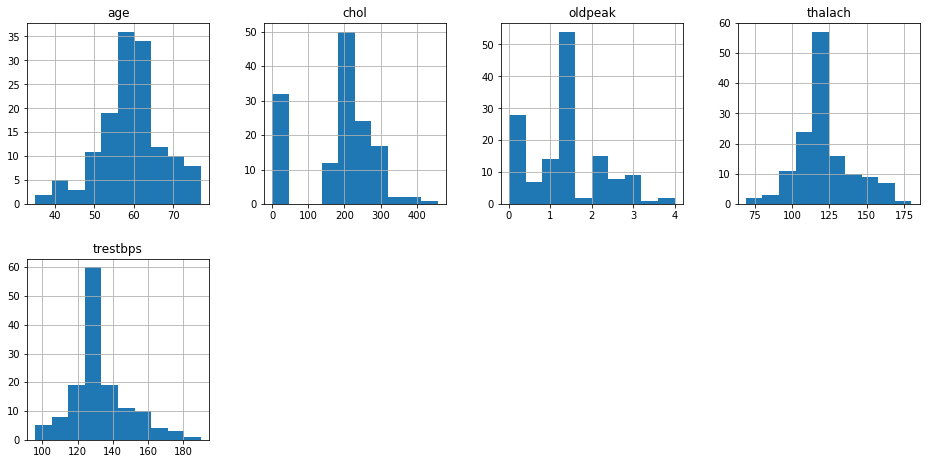

In [26]:
# Histograms for each attribute
x_train_df.hist(layout=(dispRow,dispCol))
pyplot.show()

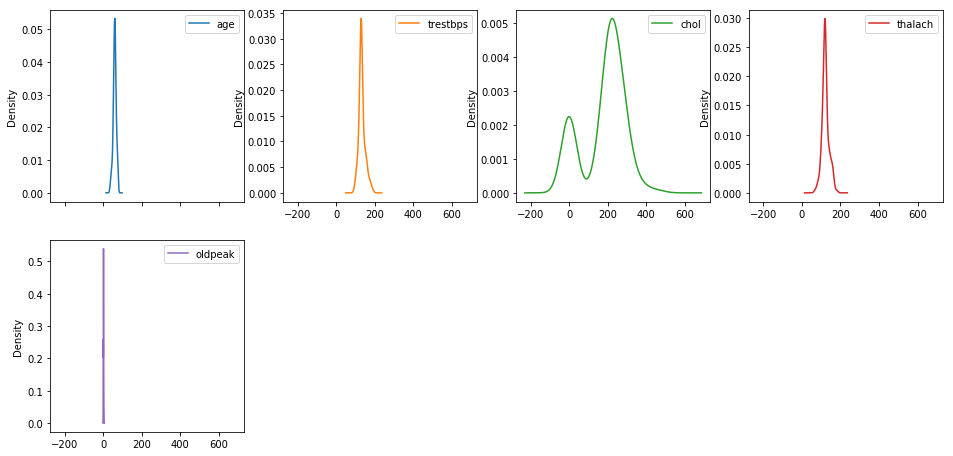

In [27]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

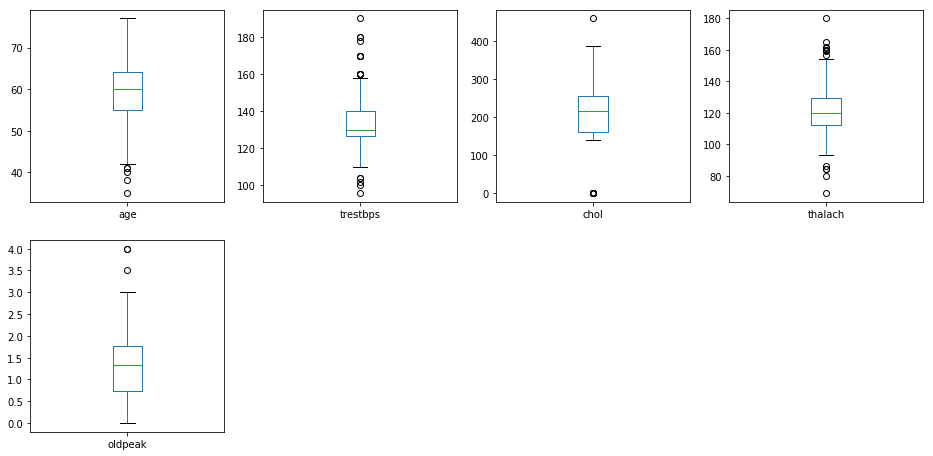

In [28]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [29]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

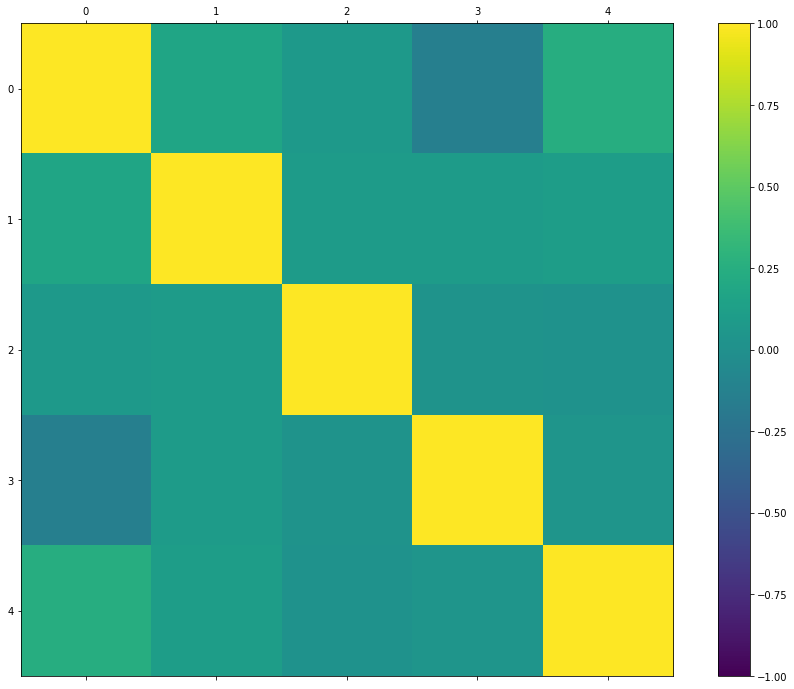

In [30]:
# Correlation matrix
fig = pyplot.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = x_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [31]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [32]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.b) Data Transforms

In [34]:
# Not applicable for this iteration of the project

### 3.c) Display the Final Datasets for Model-Building

In [35]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (140, 11) y_train.shape: (140,)
x_test.shape: (60, 11) y_test.shape: (60,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [36]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [37]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LogisticRegression(random_state=seedNum, n_jobs=cpu_num, solver='lbfgs')))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)))
# models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [38]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LR: 0.757143 (0.091473)
Model training time: 0:00:03.903502
CART: 0.707143 (0.081127)
Model training time: 0:00:00.016614
BT: 0.714286 (0.090351)
Model training time: 0:00:00.333155
RF: 0.735714 (0.127975)
Model training time: 0:00:01.436876
ET: 0.757143 (0.120374)
Model training time: 0:00:01.391845
XGB: 0.735714 (0.090633)
Model training time: 0:00:00.257573
Average metrics (accuracy) from all models: 0.7345238095238095


### 4.b) Spot-checking baseline algorithms

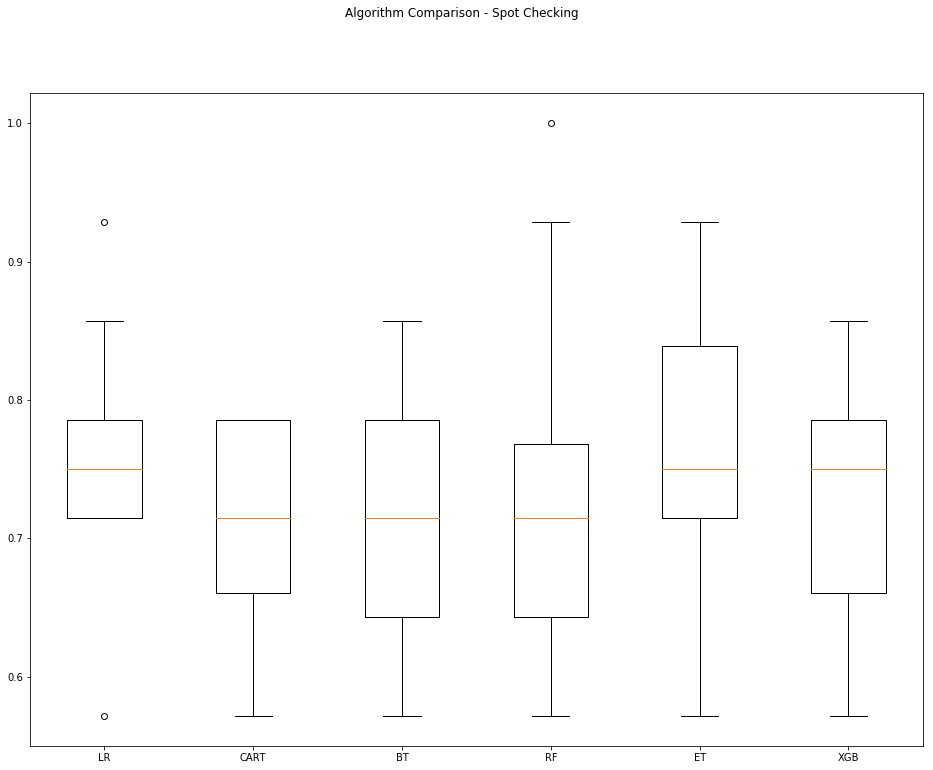

In [39]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [40]:
# Set up the comparison array
results = []
names = []

In [41]:
# Tuning algorithm #1 - Logistic Regression
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(C=np.array([1.0,0.8,0.6,0.4,0.2]))
model1 = LogisticRegression(random_state=seedNum, n_jobs=cpu_num, solver='lbfgs')
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('LR')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.757143 using {'C': 1.0}
0.757143 (0.091473) with: {'C': 1.0}
0.750000 (0.102270) with: {'C': 0.8}
0.750000 (0.097153) with: {'C': 0.6}
0.750000 (0.102270) with: {'C': 0.4}
0.750000 (0.102270) with: {'C': 0.2}
Model training time: 0:00:01.736027


In [42]:
# Tuning algorithm #2 - Extra Trees
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([10,25,50,100,125]))
model2 = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('ET')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.778571 using {'n_estimators': 25}
0.757143 (0.120374) with: {'n_estimators': 10}
0.778571 (0.092857) with: {'n_estimators': 25}
0.771429 (0.104978) with: {'n_estimators': 50}
0.757143 (0.120374) with: {'n_estimators': 100}
0.757143 (0.120374) with: {'n_estimators': 125}
Model training time: 0:00:16.278462


### 5.b) Compare Algorithms After Tuning

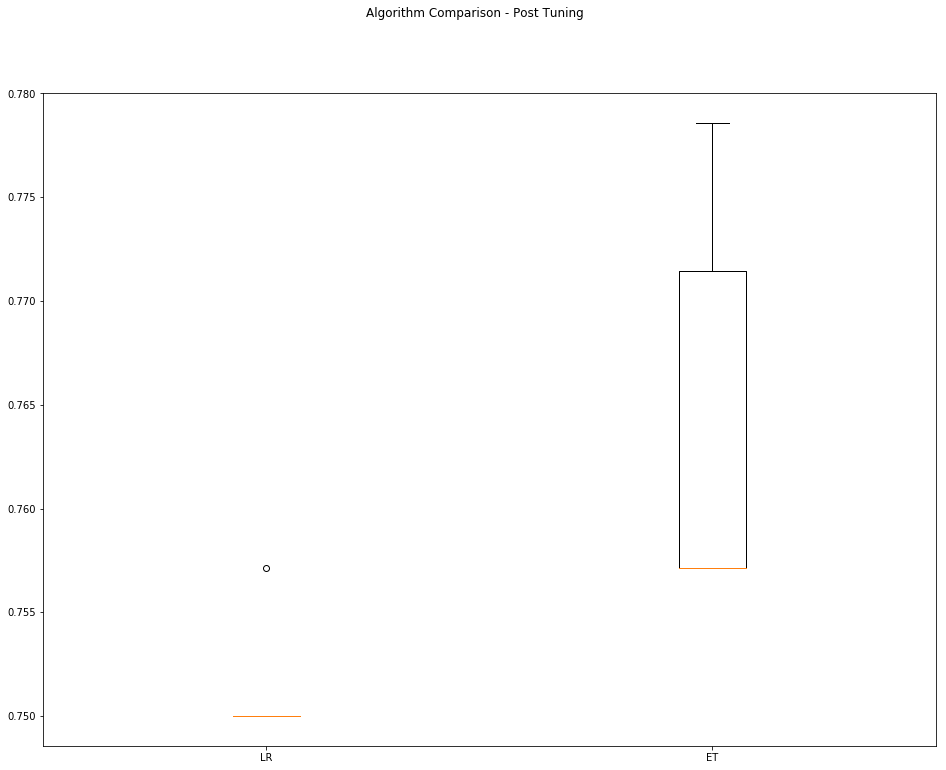

In [43]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [44]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [45]:
model = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num, n_estimators=25)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6666666666666666
[[ 3 13]
 [ 7 37]]
              precision    recall  f1-score   support

           0       0.30      0.19      0.23        16
           1       0.74      0.84      0.79        44

   micro avg       0.67      0.67      0.67        60
   macro avg       0.52      0.51      0.51        60
weighted avg       0.62      0.67      0.64        60



### 6.b) Create standalone model on entire training dataset

In [46]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num, n_estimators=25)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (200, 11) y_complete.shape: (200,)
Model training time: 0:00:00.122588


### 6.c) Save model for later use

In [47]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [48]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:06.295987
